In [107]:
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from itertools import combinations

import missingno as msno
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from BorutaShap import BorutaShap
import category_encoders as ce
import shap

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

from utils import *
import gc
gc.enable()

In [2]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

TARGET = 'TARGET'

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#### Exploratory Data Analisys

In [4]:
train, test = check_duplicates_and_constants(train, test)

Initial train shape: (76020, 371)
Initial test shape: (75818, 370)
Duplicates in train: 0
Duplicates in test: 0
ind_var2_0 in train set is constant, removed both from train and test sets.
ind_var2 in train set is constant, removed both from train and test sets.
ind_var27_0 in train set is constant, removed both from train and test sets.
ind_var28_0 in train set is constant, removed both from train and test sets.
ind_var28 in train set is constant, removed both from train and test sets.
ind_var27 in train set is constant, removed both from train and test sets.
ind_var41 in train set is constant, removed both from train and test sets.
ind_var46_0 in train set is constant, removed both from train and test sets.
ind_var46 in train set is constant, removed both from train and test sets.
num_var27_0 in train set is constant, removed both from train and test sets.
num_var28_0 in train set is constant, removed both from train and test sets.
num_var28 in train set is constant, removed both from

In [5]:
suspissious_cols = "ind_var6 ind_var13_medio_0 ind_var13_medio ind_var18_0 ind_var18 ind_var29 ind_var34_0 ind_var34 num_var6 num_var13_medio_0 num_var13_medio num_var18_0 num_var18 num_op_var40_hace3 num_var29 num_var34_0 num_var34 saldo_var6 saldo_var13_medio saldo_var18 saldo_var29 saldo_var34 delta_imp_amort_var18_1y3 delta_imp_amort_var34_1y3 delta_imp_reemb_var33_1y3 delta_imp_trasp_var33_out_1y3 delta_num_reemb_var33_1y3 delta_num_trasp_var33_out_1y3 imp_amort_var18_ult1 imp_amort_var34_ult1 imp_aport_var33_ult1 imp_var7_emit_ult1 imp_reemb_var17_hace3 imp_reemb_var33_ult1 imp_trasp_var17_in_hace3 imp_trasp_var17_in_ult1 imp_trasp_var17_out_ult1 imp_trasp_var33_in_hace3 imp_trasp_var33_in_ult1 imp_trasp_var33_out_ult1 imp_venta_var44_hace3 ind_var7_emit_ult1 num_var7_emit_ult1 num_meses_var13_medio_ult3 num_meses_var29_ult3 num_reemb_var17_hace3 num_reemb_var33_ult1 num_trasp_var17_in_hace3 num_trasp_var33_out_ult1 num_venta_var44_hace3 saldo_medio_var13_medio_hace2 saldo_medio_var13_medio_ult1 saldo_medio_var13_medio_ult3 saldo_medio_var17_hace3 saldo_medio_var29_hace2 saldo_medio_var29_hace3 saldo_medio_var29_ult1 saldo_medio_var29_ult3".split()

In [17]:
scores = calculate_feature_separating_ability(train[suspissious_cols], train[TARGET])
print(f"Rude feature selection, left: {(scores > 0).sum()}")

Rude feature selection, left: 0


In [6]:
train.drop(suspissious_cols, axis=1, inplace=True)
test.drop(suspissious_cols, axis=1, inplace=True)
train.shape, test.shape

((76020, 279), (75818, 278))

In [7]:
# remove equal columns
equal_columns = []
for col1, col2 in combinations(train.columns[1:-1], r=2):
    if np.all(train[col1] == train[col2]):
        equal_columns.append((col1, col2))

In [8]:
equal_columns = [col[1] for col in equal_columns]
train.drop(equal_columns, axis=1, inplace=True)
test.drop(equal_columns, axis=1, inplace=True)
train.shape, test.shape

((76020, 262), (75818, 261))

In [9]:
check_missings(train)

Total NA-values = 0


""
Total
Percent
Types


In [10]:
check_missings(test)

Total NA-values = 0


""
Total
Percent
Types


<AxesSubplot:>

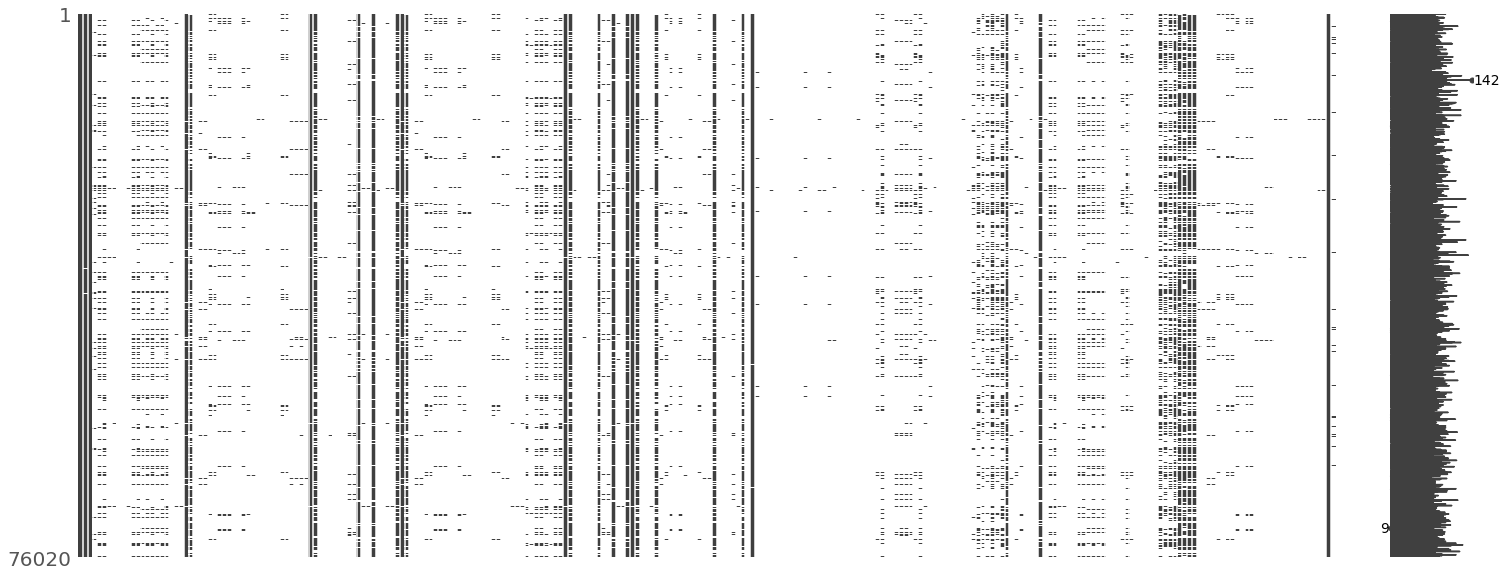

In [16]:
# visualize sparsity
msno.matrix(train.replace(0, np.nan))

In [17]:
train.select_dtypes("object").columns

Index([], dtype='object')

In [18]:
train[TARGET].value_counts(normalize=True)

0   0.9604
1   0.0396
Name: TARGET, dtype: float64

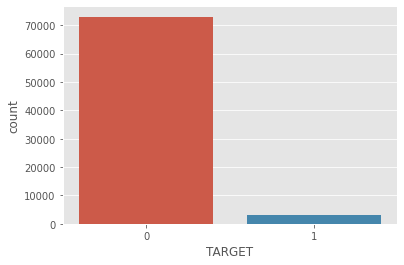

In [19]:
sns.countplot(x=TARGET, data=train)
plt.show()

In [20]:
train.describe()
# outliers: var3, all columns starting with delta_ -> replace with np.nan
# other features is highly skewed due to high amount of zero data

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var44_0,ind_var44,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13,saldo_var14,saldo_var17,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_venta_var44_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var17_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_reemb_var13_ult1,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var17_in_ult1,num_trasp_var17_out_ult1,num_trasp_var33_in_hace3,num_trasp_var33_in_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,sald

In [21]:
train["ID"].nunique() == len(train), test["ID"].nunique() == len(test)

(True, True)

In [37]:
# one of santander competitions had synthetic data in test, which leads to high prediction shift
df_test = pd.read_csv("test.csv").values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))
del df_test; gc.collect()

75818
0


In [22]:
# cardinality check
binary_columns = []
for column in train.columns[:-1]:
    if train[column].nunique() < 3:
        binary_columns.append(column)
print("Binary columns count:", len(binary_columns))
# as we are going to use GB models this may be not good having so much binary features

Binary columns count: 63


In [23]:
low_cardinality_columns = []
for column in train.columns[:-1]:
    n = train[column].nunique()
    if n > 2 and n < 20:
        low_cardinality_columns.append(column)
print("Low cardinality columns count:", len(low_cardinality_columns))

Low cardinality columns count: 80


In [24]:
# check train/test distribution: distribution is hopefully equal
check_split_equality(train.drop(["ID", TARGET], axis=1), test.drop("ID", axis=1))

CV-score: 0.5013


In [25]:
len_train = len(train)
columns_to_explore = []
for column in train.columns[1:-1]:
    num_zeros = train[column].replace(0, np.nan).isna().sum()
    if num_zeros < 0.7 * len_train:
        columns_to_explore.append(column)

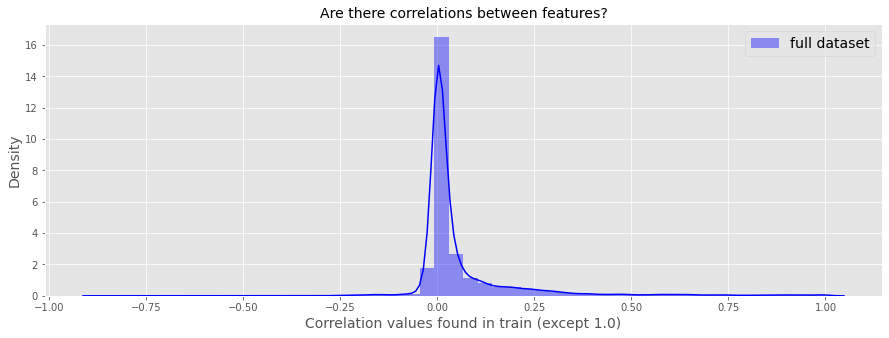

In [26]:
show_correlation_hist(train, columns=columns_to_explore)  # laplas distribution

**var38**

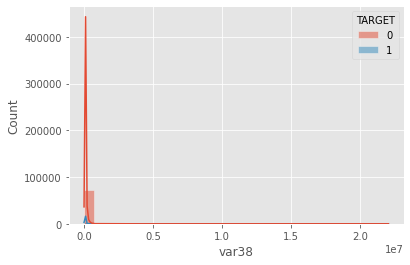

In [27]:
sns.histplot(x="var38", hue=TARGET, data=train, bins=30, kde=True)
plt.show()

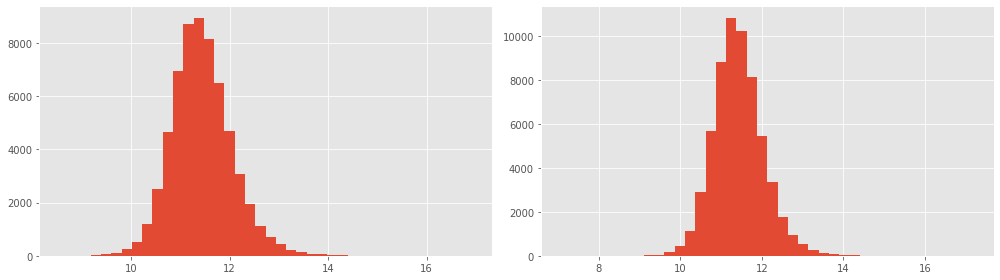

In [28]:
# most frequent value is close to feature mean in both train and test
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.hist(train.loc[~np.isclose(train.var38, 117310.979016), 'var38'].map(np.log), bins=40)
plt.subplot(122)
plt.hist(test.loc[~np.isclose(test.var38, 117310.979016), 'var38'].map(np.log), bins=40)
plt.tight_layout()
plt.show()

**num_var4**

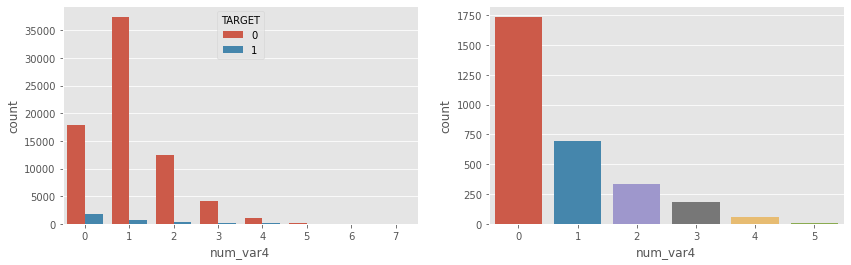

In [29]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
sns.countplot("num_var4", hue=TARGET, data=train)
plt.subplot(122)
sns.countplot("num_var4", data=train[train[TARGET] == 1])
plt.show()
# dissatisfaction dependency on number of products

**var15**

In [30]:
# age of customer
train["var15"].describe()  # we have either young (5) and very old ones (105)

count   76020.0000
mean       33.2129
std        12.9565
min         5.0000
25%        23.0000
50%        28.0000
75%        40.0000
max       105.0000
Name: var15, dtype: float64

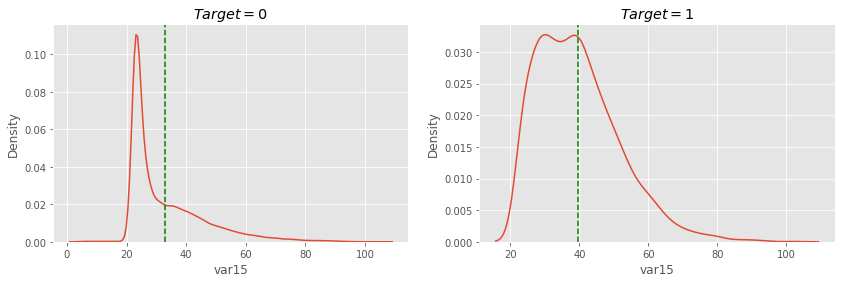

In [120]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.title("$Target = 0$")
sns.kdeplot("var15", data=train[train[TARGET] == 0])
plt.axvline(train.loc[train[TARGET] == 0, "var15"].mean(), c="green", ls="--")
plt.subplot(122)
plt.title("$Target = 1$")
sns.kdeplot("var15", data=train[train[TARGET] == 1])
plt.axvline(train.loc[train[TARGET] == 1, "var15"].mean(), c="green", ls="--")
plt.show()

**var36**

In [31]:
train["var36"].value_counts()

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

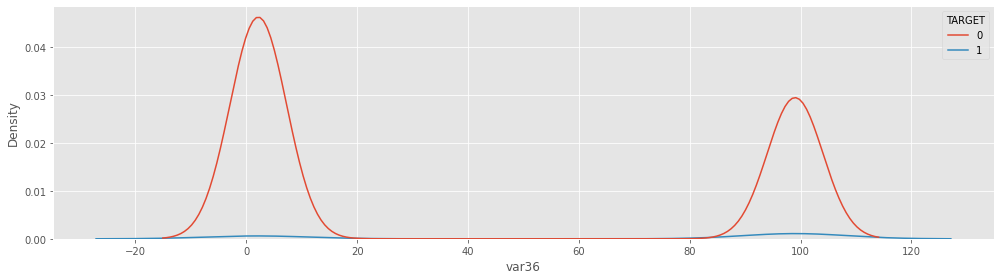

In [139]:
plt.figure(figsize=(14, 4))
sns.kdeplot(x="var36", data=train, hue=TARGET)
plt.tight_layout()
plt.show()

**num_var5**

In [32]:
train[train[TARGET]==1]["num_var5"].value_counts()

0    1959
3    1042
6       7
Name: num_var5, dtype: int64

In [145]:
train[train[TARGET]==0]["num_var5"].value_counts()

3     49223
0     23602
6       183
9         3
15        1
Name: num_var5, dtype: int64

In [146]:
test["num_var5"].value_counts()

3     50141
0     25494
6       177
9         5
12        1
Name: num_var5, dtype: int64

In [152]:
table = pd.crosstab(train["num_var5"], train[TARGET])
stats.chi2_contingency(table, correction=False)[1]

1.4064075815075909e-300

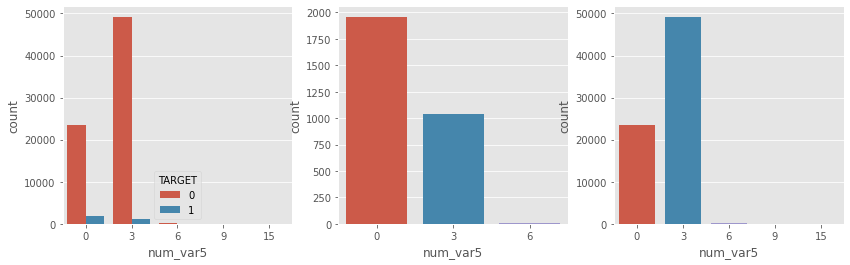

In [157]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
sns.countplot("num_var5", hue=TARGET, data=train)
plt.subplot(132)
sns.countplot("num_var5", data=train[train[TARGET] == 1])
plt.subplot(133)
sns.countplot("num_var5", data=train[train[TARGET] == 0])
plt.show()

In [174]:
stats.chi2_contingency(pd.crosstab(train["num_var5"], train[TARGET]), correction=False)[1]

1.4064075815075909e-300

**num_meses_var5_ult3**

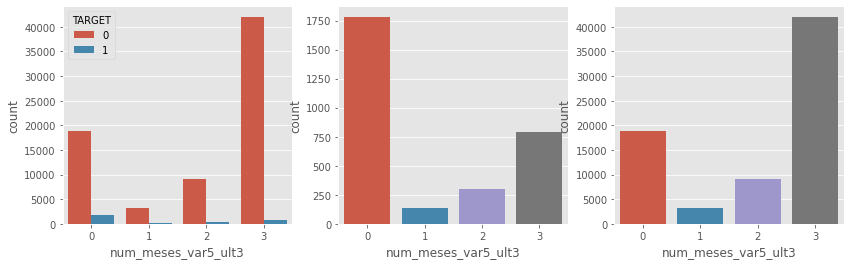

In [33]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
sns.countplot("num_meses_var5_ult3", hue=TARGET, data=train)
plt.subplot(132)
sns.countplot("num_meses_var5_ult3", data=train[train[TARGET] == 1])
plt.subplot(133)
sns.countplot("num_meses_var5_ult3", data=train[train[TARGET] == 0])
plt.show()

In [173]:
stats.chi2_contingency(pd.crosstab(train["num_meses_var5_ult3"], train[TARGET]), correction=False)[1]

0.0

In [175]:
test["num_meses_var5_ult3"].value_counts()

3    42722
0    20375
2     9453
1     3268
Name: num_meses_var5_ult3, dtype: int64

**var3**

In [34]:
train["var3"].replace(-999999, np.nan).describe()

count   75904.0000
mean        2.7176
std         9.4551
min         0.0000
25%         2.0000
50%         2.0000
75%         2.0000
max       238.0000
Name: var3, dtype: float64

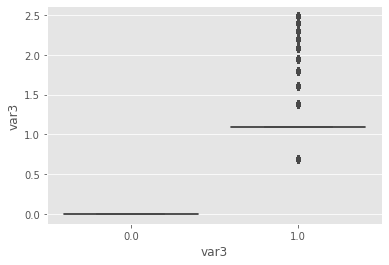

In [195]:
sns.boxplot(y=np.log1p(np.clip(train.loc[train["var3"] != -999999, "var3"], 0, 
                      np.percentile(train.loc[train["var3"] != -999999, "var3"], 99))), 
            x=np.clip(train.loc[train["var3"] != -999999, "var3"], 0, 
                      np.percentile(train.loc[train["var3"] != -999999, TARGET], 99)))
plt.show()

**Baseline check**

In [22]:
lgbm_params = {
                'boosting_type': 'gbdt',
                'n_estimators': 750, 
                'learning_rate': 0.005134,
                'num_leaves': 54,
                'max_depth': 5,  # 10
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'min_child_samples': 200,  # 20
                'categorical_feature': None
}

In [36]:
# with dropped suspissious columns
x_train, x_test, y_train, y_test = train_test_split(train.drop([TARGET, "ID"], axis=1), train[TARGET], 
                                                    test_size=0.3, random_state=seed)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=seed)

In [37]:
baseline = LGBMClassifier(**lgbm_params).fit(x_train, y_train, 
                                             eval_metric="auc", 
                                             eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                             early_stopping_rounds=50,
                                             verbose=-1)

In [38]:
train_preds = baseline.predict_proba(x_train)[:,1]
test_preds = baseline.predict_proba(x_test)[:,1]

report(y_train, train_preds>=0.5, y_test, test_preds>=0.5, train_preds, test_preds)

Train
               precision    recall  f1-score   support

           0     0.9607    1.0000    0.9799     51121
           1     0.0000    0.0000    0.0000      2093

    accuracy                         0.9607     53214
   macro avg     0.4803    0.5000    0.4900     53214
weighted avg     0.9229    0.9607    0.9414     53214

Test
               precision    recall  f1-score   support

           0     0.9588    1.0000    0.9790     10933
           1     0.0000    0.0000    0.0000       470

    accuracy                         0.9588     11403
   macro avg     0.4794    0.5000    0.4895     11403
weighted avg     0.9193    0.9588    0.9386     11403

Train ROC_AUC: 0.840, Test ROC_AUC: 0.815
Train GINI: 0.680, Test GINI: 0.630


In [39]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, test_preds, roc_auc_score))

(0.7967023017004095, 0.8319216739281556)

In [40]:
# private: 0.80349, public: 0.81820
sub_preds = baseline.predict_proba(test.drop("ID", axis=1))[:,1]
submission = pd.DataFrame(data={"ID": test["ID"], TARGET: sub_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/1.98M [00:00<?, ?B/s]
 10%|#         | 208k/1.98M [00:00<00:01, 1.46MB/s]
100%|##########| 1.98M/1.98M [00:02<00:00, 908kB/s]


In [41]:
del x_train, x_test, x_valid, y_train, y_test, y_valid; gc.collect()

80646

#### Feature Engineering

In [9]:
# concatenate datasets for kaggle. IRL - data leakage.
df = pd.concat([train, test])
del train, test; gc.collect()

0

In [10]:
df = df.replace(-999999, np.nan)
df = df.replace(9999999999, np.nan)

In [11]:
df["var38mc"] = np.isclose(df.var38, 117310.979016).astype(int)
df["logvar38"] = 0
df.loc[df["var38mc"] == 0, "logvar38"] = df.loc[df["var38mc"] == 0, "var38"].map(np.log)

df["num_var4_cat"] = df["num_var4"].astype("category")

In [12]:
df["var38_mean"] = df.groupby("num_var4_cat")["var38"].transform("mean")
df["var38_max"] = df.groupby("num_var4_cat")["var38"].transform("max")
df["var38_min"] = df.groupby("num_var4_cat")["var38"].transform("min")
df["var38_count"] = df.groupby("num_var4_cat")["var38"].transform("count")
df["var38_logsum"] = df.groupby("num_var4_cat")["var38"].transform("sum").apply(np.log1p)

In [13]:
df["age_cut"] = pd.cut(df["var15"], bins=[4, 15, 22, 30, 35, 41, 50, 60, 70, 90, 106], labels=False)

In [14]:
df["age_mean"] = df.groupby("age_cut")["var38"].transform("mean")
df["age_max"] = df.groupby("age_cut")["var38"].transform("max")
df["age_min"] = df.groupby("age_cut")["var38"].transform("min")
df["age_count"] = df.groupby("age_cut")["var38"].transform("count")
df["age_logsum"] = df.groupby("age_cut")["var38"].transform("sum").apply(np.log1p)

In [15]:
df["num_meses_var5_ult3_cat"] = df["num_meses_var5_ult3"].astype("category")

In [16]:
df["num_meses_var5_ult3_cat_mean"] = df.groupby("num_meses_var5_ult3_cat")["var38"].transform("mean")
df["num_meses_var5_ult3_cat_max"] = df.groupby("num_meses_var5_ult3_cat")["var38"].transform("max")
df["num_meses_var5_ult3_cat_min"] = df.groupby("num_meses_var5_ult3_cat")["var38"].transform("min")
df["num_meses_var5_ult3_cat_count"] = df.groupby("num_meses_var5_ult3_cat")["var38"].transform("count")
df["num_meses_var5_ult3_cat_logsum"] = df.groupby("num_meses_var5_ult3_cat")["var38"].transform("sum").apply(np.log1p)

In [17]:
df["meses_age_ratio"] = df["num_meses_var5_ult3"] / (df["var15"] + 1)
df["num_var4_age_ratio"] = df["num_var4"] / df["var15"]

In [21]:
# SVD (Note: choose only one cell - PCA, SVD or func)
scaler = StandardScaler() 
svd = TruncatedSVD(n_components=40, n_iter=15, random_state=seed)

svd_input = df.drop(["ID", TARGET], axis=1).select_dtypes("number").fillna(-1)
svd_input = scaler.fit_transform(svd_input)
svd_input = scipy.sparse.csr_array(svd_input)
svd_factors = svd.fit_transform(svd_input)

svd_features = pd.DataFrame(data=svd_factors, columns=[f"svd_{i}" for i in range(1, 41)], index=df.index)

In [31]:
svd_columns = [col for col in df.columns if col.startswith("svd_")]
df.drop(svd_columns, axis=1, inplace=True)

In [18]:
# PCA
# df.reset_index(inplace=True)

pipe = make_pipeline(StandardScaler(), PCA(n_components=None, random_state=seed))

pca_input = df.drop(["ID", TARGET], axis=1).select_dtypes("number").fillna(-1)
pca_factors = pipe.fit_transform(pca_input)

pca_features = pd.DataFrame(data=pca_factors[:, :156], columns=[f"pca_{i}" for i in range(1, 157)], index=df.index)

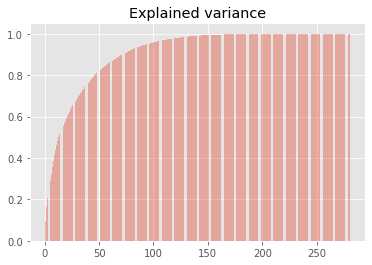

In [43]:
plt.title("Explained variance")
plt.bar(np.arange(1, pca_input.shape[1]+1), pipe[1].explained_variance_ratio_.cumsum(), alpha=0.4)
plt.show()

In [ ]:
pca_columns = [col for col in df.columns if col.startswith("pca_")]
df.drop(pca_columns, axis=1, inplace=True)

In [22]:
# SVD
df = pd.concat([df, svd_features], axis=1)
del svd_input, svd_factors, svd_features; gc.collect()

659

In [19]:
# PCA
df = pd.concat([df, pca_features], axis=1)
del pca_input, pca_factors, pca_features; gc.collect()

371

In [20]:
df.set_index("ID", inplace=True)

**Check baseline PCA/SVD**

In [21]:
train, test = df[~df[TARGET].isna()], df[df[TARGET].isna()].drop(TARGET, axis=1)

x_train, x_test, y_train, y_test = train_test_split(train.drop([TARGET,], axis=1), train[TARGET], 
                                                    test_size=0.3, random_state=seed)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=seed)

In [53]:
baseline = LGBMClassifier(**lgbm_params).fit(x_train, y_train, 
                                             eval_metric="auc", 
                                             eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                             early_stopping_rounds=50,
                                             verbose=-1)

In [57]:
baseline.best_iteration_

750

In [54]:
train_preds = baseline.predict_proba(x_train)[:,1]
test_preds = baseline.predict_proba(x_test)[:,1]

report(y_train, train_preds>=0.5, y_test, test_preds>=0.5, train_preds, test_preds)

Train
               precision    recall  f1-score   support

         0.0     0.9608    1.0000    0.9800     51121
         1.0     1.0000    0.0029    0.0057      2093

    accuracy                         0.9608     53214
   macro avg     0.9804    0.5014    0.4929     53214
weighted avg     0.9623    0.9608    0.9417     53214

Test
               precision    recall  f1-score   support

         0.0     0.9588    1.0000    0.9790     10933
         1.0     0.0000    0.0000    0.0000       470

    accuracy                         0.9588     11403
   macro avg     0.4794    0.5000    0.4895     11403
weighted avg     0.9193    0.9588    0.9386     11403

Train ROC_AUC: 0.890, Test ROC_AUC: 0.842
Train GINI: 0.781, Test GINI: 0.685


In [55]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, test_preds, roc_auc_score))

(0.8264665991705847, 0.8578278606393518)

### Compare Blending / Best single model from CV / full-data single model

In [117]:
lgbm_params2 = {
                'boosting_type': 'gbdt',
                'n_estimators': 2000, 
                'learning_rate': 0.005134,
                'num_leaves': 54,
                'max_depth': 5,
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'min_child_samples': 200,
                'categorical_feature': None,
                # 'max_bin': 128
}

optim_params = {
                'boosting_type': 'gbdt',
                'n_estimators': 2000, 
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'categorical_feature': None,
                'learning_rate': 0.03160523014570645,
                'max_depth': 4,
                'min_child_samples': 259,
                'num_leaves': 65
}

In [118]:
fold = KFold(n_splits=5, shuffle=True, random_state=seed)
lgbm_estimators, oof_scores = lightgbm_cross_validation(optim_params, 
                                                        train.drop(TARGET, axis=1).reset_index(drop=True), 
                                                        train[TARGET].reset_index(drop=True), 
                                                        cv=fold, 
                                                        rounds=50)
gc.collect()

Sat Sep 17 00:42:26 2022, Cross-Validation, 76020 rows, 438 cols
Fold 1, Train score = 0.89394, Valid score = 0.84682
Fold 2, Train score = 0.87760, Valid score = 0.83129
Fold 3, Train score = 0.88597, Valid score = 0.84548
Fold 4, Train score = 0.88468, Valid score = 0.85137
Fold 5, Train score = 0.89666, Valid score = 0.84302
Train score by each fold: [0.89394, 0.8776, 0.88597, 0.88468, 0.89666]
Valid score by each fold: [0.84682, 0.83129, 0.84548, 0.85137, 0.84302]
Train mean score by each fold:0.88777 +/- 0.00683
Valid mean score by each fold:0.84360 +/- 0.00673
**************************************************
OOF-score: 0.84337


320

In [ ]:
# SVD: 0.81741, 0.83211
# PCA: 0.82416, 0.83795
sub_preds = baseline.predict_proba(test)[:,1]
submission = pd.DataFrame(data={"ID": test.index, TARGET: sub_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

In [120]:
calculate_confidence_interval(create_bootstrap_metrics(train[TARGET], oof_scores, roc_auc_score))

(0.837326273902626, 0.850198657745938)

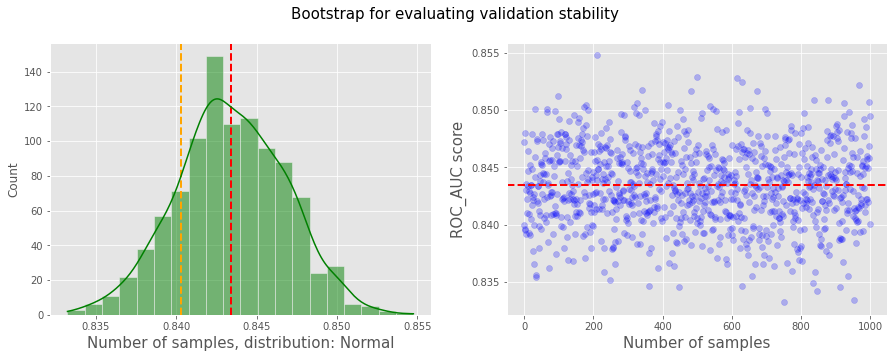

In [122]:
stability = create_bootstrap_metrics(train[TARGET], oof_scores, roc_auc_score)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(stability)), stability, alpha=0.25, color="blue")
axes[1].set_xlabel("Number of samples", size=15)
axes[1].set_ylabel("ROC_AUC score", size=15)
distribution = "Normal" if stats.shapiro(stability)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(stability), lw=2, ls='--', c='red')
axes[1].axhline(np.mean(stability), lw=2, ls='--', c='red')
axes[0].axvline(0.84029, lw=2, ls='--', c='orange')
sns.histplot(stability, ax=axes[0], color="green", bins=20, kde=True)
axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
plt.show()

In [119]:
# average: 0.82513, 0.83962 with lgbm_params, 0.82564, 0.84025 with lgbm_params2
# or best model in folds: 0.82400,  0.83804 with lgbm params2?
# optim_params: 0.82588, 0.84029
# train full data if got no overfitting
sub_preds = np.array([model.predict_proba(test)[:,1] for model in lgbm_estimators]).T.mean(axis=1)
submission = pd.DataFrame(data={"ID": test.index, TARGET: sub_preds})
submission.to_csv("submission.csv", index=False)
# !kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.02M [00:00<?, ?B/s]
 10%|#         | 208k/2.02M [00:00<00:01, 1.53MB/s]
100%|##########| 2.02M/2.02M [00:02<00:00, 980kB/s]


In [48]:
sub_preds = lgbm_estimators[3].predict_proba(test)[:,1]
submission = pd.DataFrame(data={"ID": test.index, TARGET: sub_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.02M [00:00<?, ?B/s]
 10%|#         | 208k/2.02M [00:00<00:01, 1.67MB/s]
100%|##########| 2.02M/2.02M [00:01<00:00, 1.08MB/s]


In [36]:
model = LGBMClassifier(**lgbm_params).fit(train.drop(TARGET, axis=1), train[TARGET], eval_metric="auc")

In [37]:
sub_preds = model.predict_proba(test)[:,1]
submission = pd.DataFrame(data={"ID": test.index, TARGET: sub_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.02M [00:00<?, ?B/s]
 12%|#1        | 240k/2.02M [00:00<00:01, 1.72MB/s]
 93%|#########3| 1.88M/2.02M [00:01<00:00, 1.74MB/s]
100%|##########| 2.02M/2.02M [00:02<00:00, 790kB/s] 


### Feature Selection

**Permutation importance**

In [52]:
estimator = LGBMClassifier(**lgbm_params).fit(x_train, y_train, 
                                              eval_metric="auc", 
                                              eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                              early_stopping_rounds=50,
                                              verbose=-1)

scores, deltas = calculate_permutation_importance(estimator, 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

deltas = deltas[deltas > 0].index.tolist()

100%|████████████████████████████████████████████████████████████████████████████████| 438/438 [00:59<00:00,  7.38it/s]


In [56]:
deltas = ['var15', 'saldo_var30', 'meses_age_ratio', 'saldo_medio_var5_ult3', 'saldo_medio_var5_hace2', 
          'saldo_medio_var5_hace3', 'pca_8', 'saldo_var42', 'saldo_var5', 'pca_146', 'pca_5', 'var38', 
          'saldo_medio_var5_ult1', 'pca_140', 'pca_19', 'logvar38', 'var3', 'pca_56', 'pca_62', 'pca_25', 'pca_23', 'pca_139', 
          'pca_148', 'pca_125', 'pca_150', 'pca_104', 'pca_101', 'pca_100', 'pca_92', 'pca_137', 'num_var4', 
          'num_op_var41_ult1', 'pca_117', 'num_med_var22_ult3', 'pca_114', 'pca_107', 'pca_78', 'pca_144', 'pca_120', 
          'num_var22_ult3', 'pca_96', 'pca_108', 'pca_128', 'pca_60', 'pca_145', 'pca_20', 'pca_118', 'pca_122', 'pca_109',
          'pca_16', 'pca_111', 'pca_131', 'pca_67', 'num_var30_0', 'pca_26', 'pca_46', 'pca_66', 'ind_var9_ult1', 'pca_77', 
          'pca_91', 'pca_71', 'pca_54', 'pca_9', 'pca_79', 'pca_45', 'pca_32', 'pca_124', 'num_var22_ult1', 'pca_121', 
          'pca_86', 'pca_39', 'num_var30', 'pca_27', 'pca_115', 'pca_134', 'pca_18', 'age_mean', 'num_var45_ult3', 
          'num_var45_hace2', 'imp_trans_var37_ult1', 'pca_22', 'pca_7', 'pca_31', 'pca_72', 'pca_10', 'pca_51', 'pca_142', 
          'pca_112', 'num_var22_hace3', 'num_var45_hace3', 'pca_41', 'pca_152', 'pca_105', 'saldo_medio_var8_ult3', 
          'saldo_medio_var8_ult1', 'age_count', 'pca_68', 'pca_102', 'pca_99', 'pca_147', 'saldo_medio_var8_hace2', 
          'num_op_var39_ult1', 'num_meses_var39_vig_ult3', 'pca_110', 'saldo_medio_var13_corto_hace2', 
          'saldo_medio_var12_ult3', 'pca_37']

In [123]:
optim_params = {
                'boosting_type': 'gbdt',
                'n_estimators': 2000, 
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'categorical_feature': None,
                'learning_rate': 0.02069765979418301,
                'max_depth': 4,
                'min_child_samples': 68,
                'num_leaves': 82
}

fold = KFold(n_splits=5, shuffle=True, random_state=seed)
lgbm_estimators2, oof_scores2 = lightgbm_cross_validation(optim_params, 
                                                          train.drop(TARGET, axis=1).reset_index(drop=True)[deltas], 
                                                          train[TARGET].reset_index(drop=True), 
                                                          cv=fold, 
                                                          rounds=50)
gc.collect()

Sat Sep 17 00:47:22 2022, Cross-Validation, 76020 rows, 107 cols
Fold 1, Train score = 0.88976, Valid score = 0.84600
Fold 2, Train score = 0.88320, Valid score = 0.82935
Fold 3, Train score = 0.89596, Valid score = 0.84412
Fold 4, Train score = 0.89024, Valid score = 0.85140
Fold 5, Train score = 0.89643, Valid score = 0.84101
Train score by each fold: [0.88976, 0.8832, 0.89596, 0.89024, 0.89643]
Valid score by each fold: [0.846, 0.82935, 0.84412, 0.8514, 0.84101]
Train mean score by each fold:0.89112 +/- 0.00484
Valid mean score by each fold:0.84238 +/- 0.00734
**************************************************
OOF-score: 0.84214


18423

In [124]:
calculate_confidence_interval(create_bootstrap_metrics(train[TARGET], oof_scores2, roc_auc_score))  # not in CI!

(0.8353540448093181, 0.8489419139057928)

In [125]:
# 0.82480, 0.84043 with lgbm_params2
# 0.82487, 0.84097 with optim_params
sub_preds2 = np.array([model.predict_proba(test[deltas])[:,1] for model in lgbm_estimators2]).T.mean(axis=1)
submission = pd.DataFrame(data={"ID": test.index, TARGET: sub_preds2})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.02M [00:00<?, ?B/s]
 12%|#1        | 240k/2.02M [00:00<00:01, 1.75MB/s]
 95%|#########4| 1.91M/2.02M [00:00<00:00, 3.75MB/s]
100%|##########| 2.02M/2.02M [00:02<00:00, 1.06MB/s]


**BorutaShap selection**

In [64]:
selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(train.drop(TARGET, axis=1), train[TARGET], n_trials=20, sample=False, normalize=True, verbose=True)

Warning there are missing values in your data !


  0%|          | 0/20 [00:00<?, ?it/s]

19 attributes confirmed important: ['saldo_medio_var5_hace3', 'pca_140', 'pca_123', 'pca_14', 'pca_7', 'var38', 'var15', 'saldo_var30', 'logvar38', 'age_cut', 'pca_121', 'pca_132', 'meses_age_ratio', 'pca_110', 'pca_5', 'saldo_var42', 'saldo_medio_var5_ult3', 'pca_8', 'saldo_medio_var5_hace2']
400 attributes confirmed unimportant: ['num_aport_var13_ult1', 'delta_imp_reemb_var17_1y3', 'pca_15', 'pca_92', 'imp_reemb_var17_ult1', 'pca_119', 'saldo_var13_corto', 'num_op_var40_comer_ult3', 'imp_trans_var37_ult1', 'saldo_medio_var13_largo_ult1', 'delta_imp_trasp_var33_in_1y3', 'saldo_medio_var33_ult1', 'pca_48', 'ind_var13_largo_0', 'num_meses_var33_ult3', 'pca_79', 'saldo_medio_var8_hace2', 'ind_var25_cte', 'num_meses_var5_ult3_cat_count', 'num_var32_0', 'num_var33', 'num_trasp_var17_in_ult1', 'num_var26_0', 'pca_99', 'ind_var32_cte', 'pca_89', 'pca_130', 'saldo_medio_var13_corto_hace3', 'var38_logsum', 'num_op_var41_comer_ult1', 'pca_86', 'pca_58', 'pca_49', 'num_var14', 'saldo_medio_var12

In [65]:
boruta = ['saldo_medio_var5_hace3', 'pca_140', 'pca_123', 'pca_14', 'pca_7', 'var38', 'var15', 'saldo_var30', 'logvar38', 
          'age_cut', 'pca_121', 'pca_132', 'meses_age_ratio', 'pca_110', 'pca_5', 'saldo_var42', 'saldo_medio_var5_ult3', 
          'pca_8', 'saldo_medio_var5_hace2', 'imp_op_var41_efect_ult3', 'pca_34', 'pca_19', 'pca_153', 'saldo_medio_var5_ult1',
          'pca_4', 'pca_47', 'pca_126', 'pca_61', 'pca_62', 'pca_29', 'pca_134', 'pca_11', 'pca_143', 'pca_2', 
          'num_var4_age_ratio', 'pca_137', 'ind_var30', 'pca_139']

In [68]:
mix_feats = list(set(boruta) | set(deltas))

In [126]:
optim_params = {
                'boosting_type': 'gbdt',
                'n_estimators': 2000, 
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'categorical_feature': None,
                'learning_rate': 0.04032895204328553,
                'max_depth': 4,
                'min_child_samples': 246,
                'num_leaves': 37
}

fold = KFold(n_splits=5, shuffle=True, random_state=seed)
lgbm_estimators3, oof_scores3 = lightgbm_cross_validation(optim_params, 
                                                          train.drop(TARGET, axis=1).reset_index(drop=True)[boruta], 
                                                          train[TARGET].reset_index(drop=True), 
                                                          cv=fold, 
                                                          rounds=50)
gc.collect()

Sat Sep 17 00:49:44 2022, Cross-Validation, 76020 rows, 38 cols
Fold 1, Train score = 0.87947, Valid score = 0.84310
Fold 2, Train score = 0.87476, Valid score = 0.83179
Fold 3, Train score = 0.87437, Valid score = 0.84335
Fold 4, Train score = 0.87455, Valid score = 0.85023
Fold 5, Train score = 0.87506, Valid score = 0.84058
Train score by each fold: [0.87947, 0.87476, 0.87437, 0.87455, 0.87506]
Valid score by each fold: [0.8431, 0.83179, 0.84335, 0.85023, 0.84058]
Train mean score by each fold:0.87564 +/- 0.00193
Valid mean score by each fold:0.84181 +/- 0.00595
**************************************************
OOF-score: 0.84156


311

In [127]:
calculate_confidence_interval(create_bootstrap_metrics(train[TARGET], oof_scores3, roc_auc_score))

(0.8351019497009247, 0.8478840277163194)

In [128]:
# 0.82468, 0.83833 with lgbm_params2
# 0.82468, 0.83796 with optim_params
sub_preds3 = np.array([model.predict_proba(test[boruta])[:,1] for model in lgbm_estimators3]).T.mean(axis=1)
submission = pd.DataFrame(data={"ID": test.index, TARGET: sub_preds3})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.02M [00:00<?, ?B/s]
 10%|#         | 208k/2.02M [00:00<00:01, 1.48MB/s]
 92%|#########2| 1.87M/2.02M [00:00<00:00, 3.75MB/s]
100%|##########| 2.02M/2.02M [00:01<00:00, 1.07MB/s]


**mixed selections**

In [129]:
optim_params = {
                'boosting_type': 'gbdt',
                'n_estimators': 2000, 
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'categorical_feature': None,
                'learning_rate': 0.03578898263256464,
                'max_depth': 4,
                'min_child_samples': 120,
                'num_leaves': 22
}

fold = KFold(n_splits=5, shuffle=True, random_state=seed)
lgbm_estimators4, oof_scores4 = lightgbm_cross_validation(optim_params, 
                                                          train.drop(TARGET, axis=1).reset_index(drop=True)[mix_feats], 
                                                          train[TARGET].reset_index(drop=True), 
                                                          cv=fold, 
                                                          rounds=50)
gc.collect()

Sat Sep 17 00:51:39 2022, Cross-Validation, 76020 rows, 124 cols
Fold 1, Train score = 0.88514, Valid score = 0.84671
Fold 2, Train score = 0.87903, Valid score = 0.83187
Fold 3, Train score = 0.88382, Valid score = 0.84547
Fold 4, Train score = 0.89206, Valid score = 0.85185
Fold 5, Train score = 0.90201, Valid score = 0.84216
Train score by each fold: [0.88514, 0.87903, 0.88382, 0.89206, 0.90201]
Valid score by each fold: [0.84671, 0.83187, 0.84547, 0.85185, 0.84216]
Train mean score by each fold:0.88841 +/- 0.00798
Valid mean score by each fold:0.84361 +/- 0.00665
**************************************************
OOF-score: 0.84336


324

In [130]:
calculate_confidence_interval(create_bootstrap_metrics(train[TARGET], oof_scores4, roc_auc_score))  # not in CI!

(0.8369343597877731, 0.8496256305644411)

In [131]:
# 0.82521, 0.84056 with lgbm_params2
# 0.82630, 0.84101 with optim_params
sub_preds4 = np.array([model.predict_proba(test[mix_feats])[:,1] for model in lgbm_estimators4]).T.mean(axis=1)
submission = pd.DataFrame(data={"ID": test.index, TARGET: sub_preds4})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.02M [00:00<?, ?B/s]
 12%|#2        | 256k/2.02M [00:00<00:01, 1.76MB/s]
 93%|#########3| 1.88M/2.02M [00:00<00:00, 3.62MB/s]
100%|##########| 2.02M/2.02M [00:02<00:00, 1.05MB/s]


### Stacking

In [ ]:
# mean_scores, meta-classifier: LDA or LogREg

In [132]:
oof_predictions = pd.DataFrame(data={'m1': oof_scores, 'm2': oof_scores2, 'm3': oof_scores3, 'm4': oof_scores4, })
test_probs = pd.DataFrame(data={'m1': sub_preds, 'm2': sub_preds2, 'm3': sub_preds3, 'm4': sub_preds4, })

In [133]:
mean_scores(oof_predictions, train[TARGET])

AMean score: 0.84385
GMean score: 0.84389
Rank  score: 0.84388
GMean  rank: 0.84389


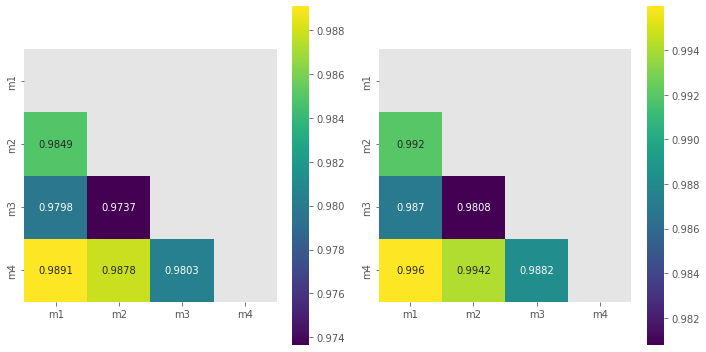

In [134]:
corr = oof_predictions.corr()
corr2 = test_probs.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes[0])
sns.heatmap(corr2, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes[1])
plt.tight_layout()
plt.show()

In [135]:
# 0.82561, 0.84033 with not optimized params
# 0.82618, 0.84080 with optim params
gmean_sub_preds = stats.gmean(test_probs, axis=1)
submission = pd.DataFrame(data={"ID": test.index, TARGET: gmean_sub_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.02M [00:00<?, ?B/s]
 10%|#         | 208k/2.02M [00:00<00:01, 1.51MB/s]
100%|##########| 2.02M/2.02M [00:02<00:00, 831kB/s]


In [136]:
# 0.82561, 0.84028 with not optimized params
# 0.82622, 0.84071 with optimized params
amean_sub_preds = np.mean(test_probs, axis=1)
submission = pd.DataFrame(data={"ID": test.index, TARGET: amean_sub_preds})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.02M [00:00<?, ?B/s]
 11%|#1        | 232k/2.02M [00:00<00:01, 1.60MB/s]
 94%|#########4| 1.91M/2.02M [00:00<00:00, 9.39MB/s]
100%|##########| 2.02M/2.02M [00:02<00:00, 964kB/s] 


In [137]:
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=lda,
                                                             X=oof_predictions,
                                                             y=train[TARGET].reset_index(drop=True),
                                                             cv=KFold(n_splits=10, shuffle=True, random_state=seed))

Fold 1, Train score: 0.84283, Valid score = 0.85435
Fold 2, Train score: 0.84447, Valid score = 0.84052
Fold 3, Train score: 0.84684, Valid score = 0.81763
Fold 4, Train score: 0.84362, Valid score = 0.84752
Fold 5, Train score: 0.84319, Valid score = 0.85094
Fold 6, Train score: 0.84412, Valid score = 0.84190
Fold 7, Train score: 0.84260, Valid score = 0.85512
Fold 8, Train score: 0.84331, Valid score = 0.84986
Fold 9, Train score: 0.84332, Valid score = 0.84923
Fold 10, Train score: 0.84475, Valid score = 0.83653
Train score by each fold: [0.84283, 0.84447, 0.84684, 0.84362, 0.84319, 0.84412, 0.8426, 0.84331, 0.84332, 0.84475]
Valid score by each fold: [0.85435, 0.84052, 0.81763, 0.84752, 0.85094, 0.8419, 0.85512, 0.84986, 0.84923, 0.83653]
Train mean score by each fold:0.84391 +/- 0.00118
Valid mean score by each fold:0.84436 +/- 0.01058
**************************************************


In [138]:
calculate_confidence_interval(create_bootstrap_metrics(train[TARGET], oof_preds_lda, roc_auc_score))

(0.8363075049238736, 0.8496996223187078)

In [141]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_lda]).T
test_fin = pd.DataFrame(data=test_fin)
test_fin = np.average(test_fin, axis=1) # 0.82562, 0.84010 / optimized: 0.82633, 0.84081

# test_fin = stats.gmean(test_fin, axis=1)  # 0.82562, 0.84010 / optimized 0.82632, 0.84082
submission = pd.DataFrame(data={"ID": test.index, TARGET: test_fin})
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m "Message"

Successfully submitted to Santander Customer Satisfaction



  0%|          | 0.00/2.03M [00:00<?, ?B/s]
 11%|#1        | 232k/2.03M [00:00<00:01, 1.61MB/s]
 66%|######5   | 1.34M/2.03M [00:00<00:00, 6.45MB/s]
100%|##########| 2.03M/2.03M [00:01<00:00, 1.09MB/s]


### Vizualize results

In [143]:
get_best_threshold(train[TARGET], y_score=oof_preds_lda)

(0.24910809993572283, 0.2869051754081278)

Confusion matrix, without normalization


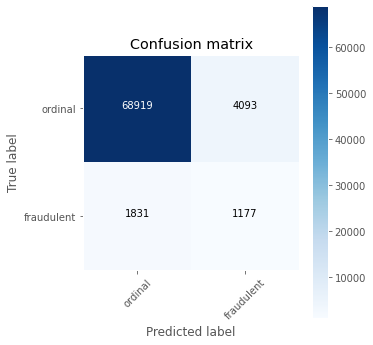

In [144]:
cnf_matrix = confusion_matrix(train[TARGET], oof_preds_lda>=0.2869051754081278)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['ordinal', 'fraudulent'], normalize=False, title='Confusion matrix',)
plt.show()

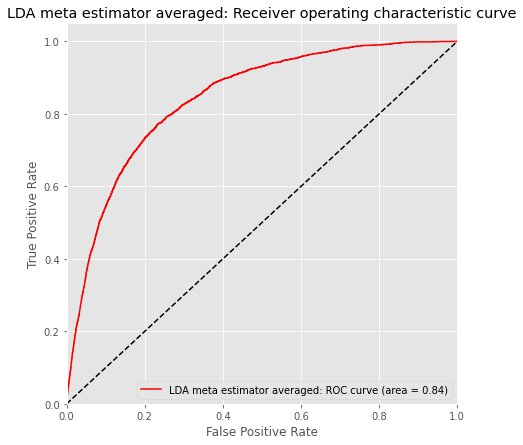

In [146]:
fpr, tpr, roc_thresholds = roc_curve(train[TARGET], oof_preds_lda)
precision, recall, pr_thresholds = precision_recall_curve(train[TARGET], oof_preds_lda)

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "LDA meta estimator averaged", color='r')

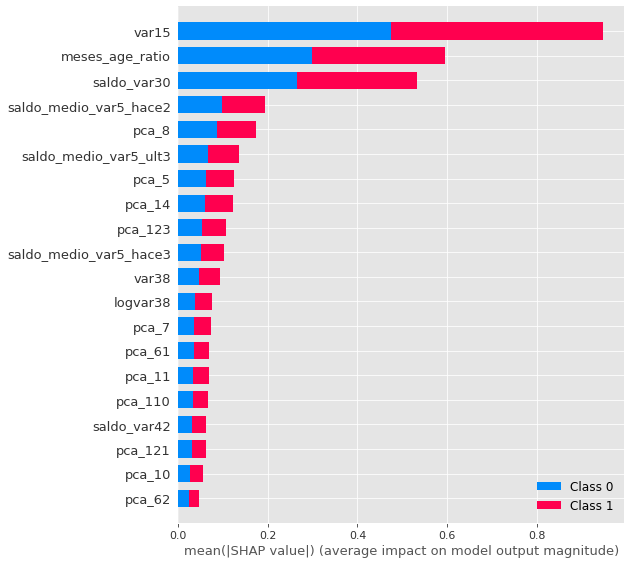

In [149]:
shap_values = shap.TreeExplainer(lgbm_estimators[3]).shap_values(train.drop([TARGET], axis=1))

shap.initjs()
shap.summary_plot(shap_values, train.drop([TARGET], axis=1))

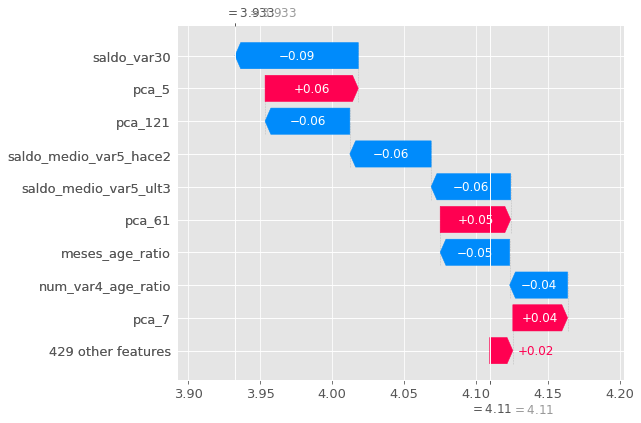

In [160]:
explainer = shap.explainers.Tree(lgbm_estimators[3])
shap_values = explainer(test)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[100].values[:, 0],
                                        feature_names=test.columns)

### Appendix: hyperparameters tunning

In [103]:
# mix features
start_params = {
                'boosting_type': 'gbdt',
                'n_estimators': 2000, 
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'verbose': -1,
                'categorical_feature': None,
}


def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 4, 12),
                    'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.3),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 100),
                    'min_child_samples': trial.suggest_int('min_child_samples', 2, 300)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 train.drop(TARGET, axis=1).reset_index(drop=True)[mix_feats], 
                                                 train[TARGET].reset_index(drop=True), 
                                                 cv=fold, 
                                                 rounds=50,
                                                 verbose=False)
    
    
    return score

In [109]:
%%time
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=10000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

Number of completed trials: 1379
Best trial
Best score: 0.8436119999999999
Best params
{'learning_rate': 0.03578898263256464,
 'max_depth': 4,
 'min_child_samples': 120,
 'num_leaves': 22}
CPU times: total: 1d 16h 39min 40s
Wall time: 2h 46min 41s


In [110]:
# boruta
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 4, 12),
                    'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.3),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 100),
                    'min_child_samples': trial.suggest_int('min_child_samples', 2, 300)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 train.drop(TARGET, axis=1).reset_index(drop=True)[boruta], 
                                                 train[TARGET].reset_index(drop=True), 
                                                 cv=fold, 
                                                 rounds=50,
                                                 verbose=False)
    
    
    return score

In [111]:
%%time
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=10000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

Number of completed trials: 1500
Best trial
Best score: 0.8418100000000001
Best params
{'learning_rate': 0.04032895204328553,
 'max_depth': 4,
 'min_child_samples': 246,
 'num_leaves': 37}
CPU times: total: 22h 59min 23s
Wall time: 1h 29min 32s


In [112]:
# deltas
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 4, 12),
                    'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.3),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 100),
                    'min_child_samples': trial.suggest_int('min_child_samples', 2, 300)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 train.drop(TARGET, axis=1).reset_index(drop=True)[deltas], 
                                                 train[TARGET].reset_index(drop=True), 
                                                 cv=fold, 
                                                 rounds=50,
                                                 verbose=False)
    
    
    return score

In [113]:
%%time
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=10000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

Number of completed trials: 1246
Best trial
Best score: 0.842376
Best params
{'learning_rate': 0.02069765979418301,
 'max_depth': 4,
 'min_child_samples': 68,
 'num_leaves': 82}
CPU times: total: 1d 17h 59min 5s
Wall time: 2h 46min 44s


In [114]:
# full
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 4, 12),
                    'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.3),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 100),
                    'min_child_samples': trial.suggest_int('min_child_samples', 2, 300)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 train.drop(TARGET, axis=1).reset_index(drop=True), 
                                                 train[TARGET].reset_index(drop=True), 
                                                 cv=fold, 
                                                 rounds=50,
                                                 verbose=False)
    
    
    return score

In [115]:
%%time
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=10000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

Number of completed trials: 685
Best trial
Best score: 0.843596
Best params
{'learning_rate': 0.03160523014570645,
 'max_depth': 4,
 'min_child_samples': 259,
 'num_leaves': 65}
CPU times: total: 1d 13h 8min 1s
Wall time: 2h 46min 45s
